In [4]:
import enum
import itertools
from enum import Enum
from typing import NamedTuple

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import scipy.stats

from endfield_gacha_model import *
from plot_tools import *


transition matrix:
[[0.004 0.004 0.    ... 0.    0.    0.08 ]
 [0.    0.008 0.    ... 0.    0.    0.08 ]
 [0.004 0.004 0.    ... 0.    0.    0.08 ]
 ...
 [0.5   0.5   0.    ... 0.    0.    0.   ]
 [0.    1.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    1.   ]]


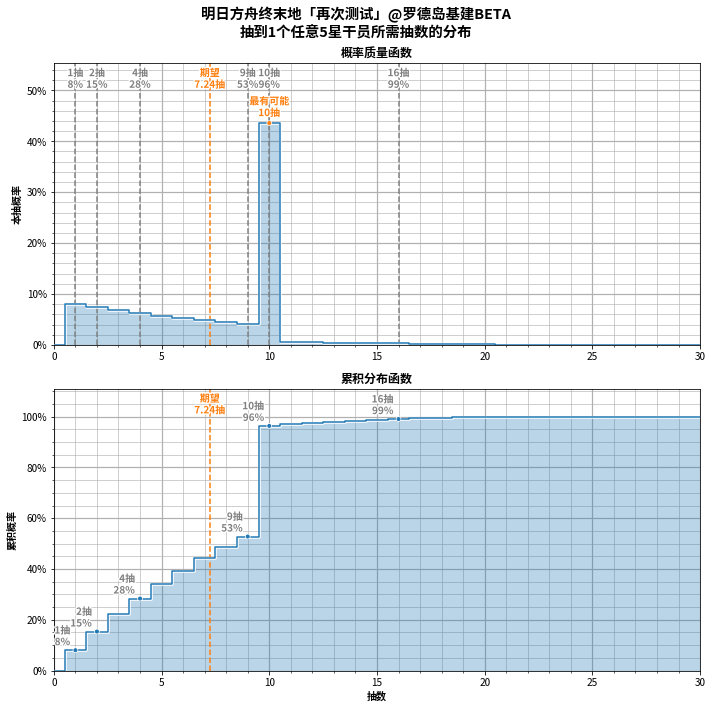

In [162]:
# 1个任意5星干员

type 状态类 = 过渡态类 | 吸收态类


class 过渡态类(NamedTuple):
    水位_6星干员: int
    水位_5星干员: int
    已抽出UP6星干员: bool


class 吸收态类(Enum):
    已抽出5星干员 = enum.auto()


def 状态转移_非第120抽(起始状态: 状态类) -> list[tuple[状态类, float]]:
    转移概率列表: list[tuple[状态类, float]] = []

    if 起始状态 == 吸收态类.已抽出5星干员:
        转移概率列表.append((吸收态类.已抽出5星干员, 1))

    elif isinstance(起始状态, 过渡态类):
        六星概率 = operator_pity_6x[起始状态.水位_6星干员+1]
        五星概率 = operator_pity_5x[起始状态.水位_5星干员+1]
        五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
        四星概率 = 1 - 六星概率 - 五星概率

        # 抽到UP6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=True), 六星概率 * 抽到6星干员时是UP6星干员的概率))

        # 抽到其他6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=起始状态.已抽出UP6星干员), 六星概率 * (1 - 抽到6星干员时是UP6星干员的概率)))

        if 起始状态.水位_6星干员 < 79:
            # 抽到5星干员
            转移概率列表.append((吸收态类.已抽出5星干员, 五星概率))

            if 起始状态.水位_5星干员 < 9:
                # 抽到4星干员
                转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=起始状态.水位_5星干员+1, 已抽出UP6星干员=起始状态.已抽出UP6星干员), 四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


def 状态转移_第120抽(起始状态: 状态类) -> list[tuple[状态类, float]]:
    if isinstance(起始状态, 过渡态类) and not 起始状态.已抽出UP6星干员:
        return [(过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=True), 1)]
    else:
        return 状态转移_非第120抽(起始状态)


状态列表 = []
状态列表.extend(过渡态类(水位_6星干员=i, 水位_5星干员=j, 已抽出UP6星干员=k) for i in range(80) for j in range(10) for k in (False, True))
状态列表.append(吸收态类.已抽出5星干员)

初始状态 = 过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=False)
最终状态 = 吸收态类.已抽出5星干员

迭代次数 = 500

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵_非第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_非第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_非第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_非第120抽 = 状态转移矩阵_非第120抽.tocsr()

状态转移矩阵_第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_第120抽 = 状态转移矩阵_第120抽.tocsr()

cdf = np.zeros(迭代次数)
状态分布 = np.zeros(状态数量)
状态分布[状态索引[初始状态]] = 1
for i in range(迭代次数):
    状态转移矩阵 = 状态转移矩阵_第120抽 if i == 119 else 状态转移矩阵_非第120抽
    cdf[i] = 状态分布[状态索引[最终状态]]
    状态分布 = 状态分布 @ 状态转移矩阵

pmf = np.diff(cdf, prepend=0)
dist = gg.FiniteDist(pmf)
# dist.calc_dist_attribution(p_error=1)
quantile_poses = [0.01, 0.1, 0.25, 0.5, 0.9, 0.99]

draw_pmf_cdf_fig(dist, "抽到1个任意5星干员所需抽数的分布", quantile_poses, drawstyle="steps-mid", x_max=30)
print("transition matrix:")
print(状态转移矩阵.toarray())


(<Figure size 720x720 with 2 Axes>,
 (<Axes: title={'center': '概率质量函数'}, ylabel='本抽概率'>,
  <Axes: title={'center': '累积分布函数'}, xlabel='抽数', ylabel='累积概率'>))

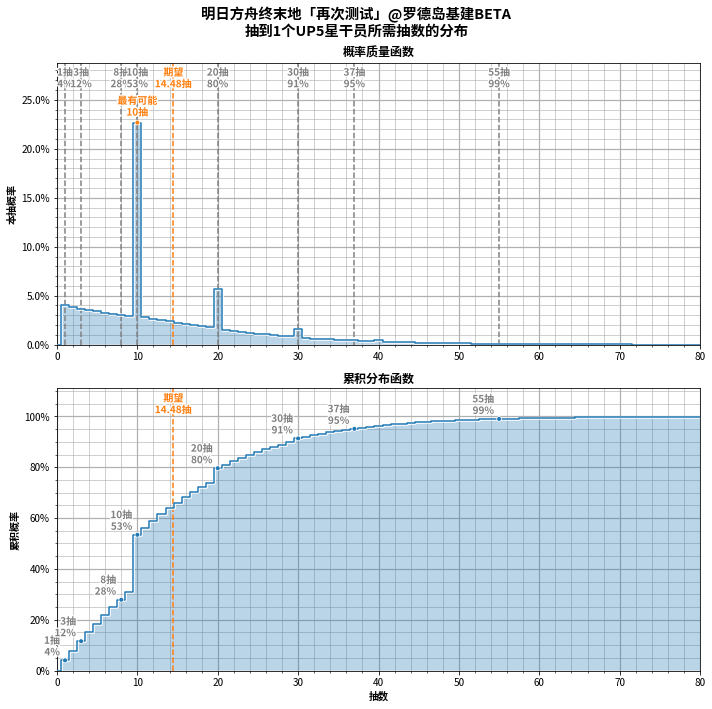

In [3]:
# 抽到1个UP5星干员所需抽数的分布

type 状态 = 过渡态类 | 吸收态类


class 过渡态类(NamedTuple):
    水位_6星干员: int
    水位_5星干员: int
    已抽出UP6星干员: bool


class 吸收态类(Enum):
    已抽出UP5星干员 = enum.auto()


def 状态转移_非第120抽(起始状态: 状态) -> list[tuple[状态, float]]:
    转移概率列表: list[tuple[状态, float]] = []

    if 起始状态 == 吸收态类.已抽出UP5星干员:
        转移概率列表.append((吸收态类.已抽出UP5星干员, 1))

    elif isinstance(起始状态, 过渡态类):
        六星概率 = operator_pity_6x[起始状态.水位_6星干员+1]
        五星概率 = operator_pity_5x[起始状态.水位_5星干员+1]
        五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
        四星概率 = 1 - 六星概率 - 五星概率

        # 抽到UP6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=True), 六星概率 * 抽到6星干员时是UP6星干员的概率))

        # 抽到其他6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=起始状态.已抽出UP6星干员), 六星概率 * (1 - 抽到6星干员时是UP6星干员的概率)))

        if 起始状态.水位_6星干员 < 79:
            # 抽到UP5星干员
            转移概率列表.append((吸收态类.已抽出UP5星干员, 五星概率 * 抽到5星干员时是UP5星干员的概率))

            # 抽到其他5星干员
            转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0, 已抽出UP6星干员=起始状态.已抽出UP6星干员), 五星概率 * (1 - 抽到5星干员时是UP5星干员的概率)))

            if 起始状态.水位_5星干员 < 9:
                # 抽到4星干员
                转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=起始状态.水位_5星干员+1, 已抽出UP6星干员=起始状态.已抽出UP6星干员), 四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


def 状态转移_第120抽(起始状态: 状态) -> list[tuple[状态, float]]:
    if isinstance(起始状态, 过渡态类) and not 起始状态.已抽出UP6星干员:
        return [(过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=True), 1)]
    else:
        return 状态转移_非第120抽(起始状态)


状态列表 = []
状态列表.extend(过渡态类(水位_6星干员=i, 水位_5星干员=j, 已抽出UP6星干员=k) for i in range(80) for j in range(10) for k in (False, True))
状态列表.append(吸收态类.已抽出UP5星干员)

初始状态 = 过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=False)
最终状态 = 吸收态类.已抽出UP5星干员

迭代次数 = 500

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵_非第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_非第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_非第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_非第120抽 = 状态转移矩阵_非第120抽.tocsr()

状态转移矩阵_第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_第120抽 = 状态转移矩阵_第120抽.tocsr()

cdf = np.zeros(迭代次数)
状态分布 = np.zeros(状态数量)
状态分布[状态索引[初始状态]] = 1
for i in range(迭代次数):
    状态转移矩阵 = 状态转移矩阵_第120抽 if i == 119 else 状态转移矩阵_非第120抽
    cdf[i] = 状态分布[状态索引[最终状态]]
    状态分布 = 状态分布 @ 状态转移矩阵

pmf = np.diff(cdf, prepend=0)
dist = gg.FiniteDist(pmf)
# dist.calc_dist_attribution(p_error=1)
quantile_poses = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

draw_pmf_cdf_fig(dist, "抽到1个UP5星干员所需抽数的分布", quantile_poses, drawstyle="steps-mid", x_max=80)


(<Figure size 720x720 with 2 Axes>,
 (<Axes: title={'center': '概率质量函数'}, ylabel='本抽概率'>,
  <Axes: title={'center': '累积分布函数'}, xlabel='抽数', ylabel='累积概率'>))

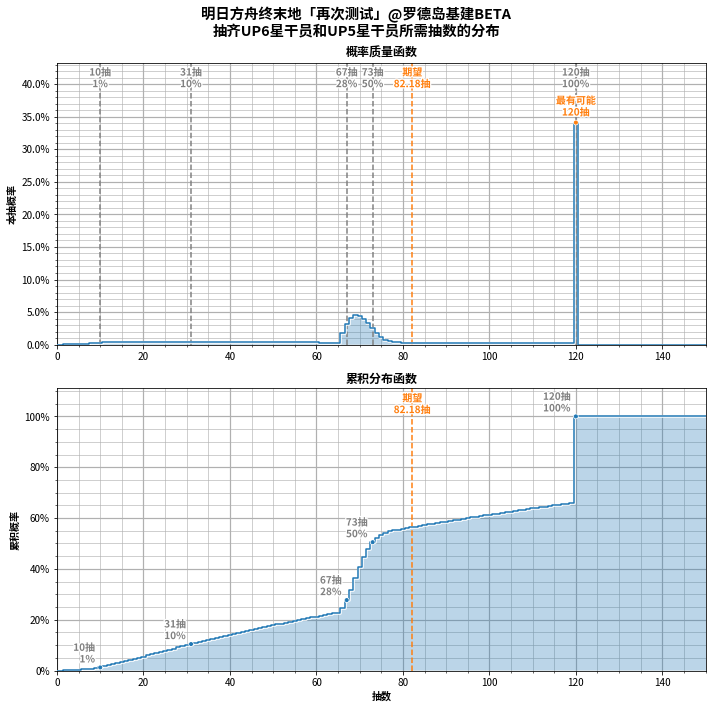

In [4]:
# 抽齐UP6星干员和UP5星干员

type 状态 = 过渡态类 | 吸收态类


class 过渡态类(NamedTuple):
    水位_6星干员: int
    水位_5星干员: int
    已抽出UP6星干员: bool
    已抽出UP5星干员: bool


class 吸收态类(Enum):
    已抽出UP6星干员和UP5星干员 = enum.auto()


def 获取状态(水位_6星干员: int, 水位_5星干员: int, 已抽出UP6星干员: bool, 已抽出UP5星干员: bool) -> 状态:
    if 已抽出UP6星干员 and 已抽出UP5星干员:
        return 吸收态类.已抽出UP6星干员和UP5星干员
    else:
        return 过渡态类(水位_6星干员=水位_6星干员, 水位_5星干员=水位_5星干员, 已抽出UP6星干员=已抽出UP6星干员, 已抽出UP5星干员=已抽出UP5星干员)


def 状态转移_非第120抽(起始状态: 状态) -> list[tuple[状态, float]]:
    转移概率列表: list[tuple[状态, float]] = []

    if 起始状态 == 吸收态类.已抽出UP6星干员和UP5星干员:
        转移概率列表.append((吸收态类.已抽出UP6星干员和UP5星干员, 1))

    elif isinstance(起始状态, 过渡态类):
        六星概率 = operator_pity_6x[起始状态.水位_6星干员+1]
        五星概率 = operator_pity_5x[起始状态.水位_5星干员+1]
        五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
        四星概率 = 1 - 六星概率 - 五星概率

        # 抽到UP6星干员
        转移概率列表.append((获取状态(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=True, 已抽出UP5星干员=起始状态.已抽出UP5星干员), 六星概率 * 抽到6星干员时是UP6星干员的概率))

        # 抽到其他6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=起始状态.已抽出UP6星干员, 已抽出UP5星干员=起始状态.已抽出UP5星干员),
                       六星概率 * (1 - 抽到6星干员时是UP6星干员的概率)))

        if 起始状态.水位_6星干员 < 79:
            # 抽到UP5星干员
            转移概率列表.append((获取状态(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0, 已抽出UP6星干员=起始状态.已抽出UP6星干员, 已抽出UP5星干员=True),
                           五星概率 * 抽到5星干员时是UP5星干员的概率))

            # 抽到其他5星干员
            转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0, 已抽出UP6星干员=起始状态.已抽出UP6星干员, 已抽出UP5星干员=起始状态.已抽出UP5星干员),
                           五星概率 * (1 - 抽到5星干员时是UP5星干员的概率)))

            if 起始状态.水位_5星干员 < 9:
                # 抽到4星干员
                转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1,
                                    水位_5星干员=起始状态.水位_5星干员+1,
                                    已抽出UP6星干员=起始状态.已抽出UP6星干员,
                                    已抽出UP5星干员=起始状态.已抽出UP5星干员),
                               四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


def 状态转移_第120抽(起始状态: 状态) -> list[tuple[状态, float]]:
    if isinstance(起始状态, 过渡态类) and not 起始状态.已抽出UP6星干员:
        return [(获取状态(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=True, 已抽出UP5星干员=起始状态.已抽出UP5星干员), 1)]
    else:
        return 状态转移_非第120抽(起始状态)


状态列表 = []
状态列表.extend(过渡态类(水位_6星干员=i, 水位_5星干员=j, 已抽出UP6星干员=k, 已抽出UP5星干员=l)
            for i in range(80)
            for j in range(10)
            for k, l in ((False, False), (False, True), (True, False)))
状态列表.append(吸收态类.已抽出UP6星干员和UP5星干员)

初始状态 = 过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=False, 已抽出UP5星干员=False)
最终状态 = 吸收态类.已抽出UP6星干员和UP5星干员

迭代次数 = 500

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵_非第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_非第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_非第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_非第120抽 = 状态转移矩阵_非第120抽.tocsr()

状态转移矩阵_第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_第120抽 = 状态转移矩阵_第120抽.tocsr()

cdf = np.zeros(迭代次数)
状态分布 = np.zeros(状态数量)
状态分布[状态索引[初始状态]] = 1
for i in range(迭代次数):
    状态转移矩阵 = 状态转移矩阵_第120抽 if i == 119 else 状态转移矩阵_非第120抽
    cdf[i] = 状态分布[状态索引[最终状态]]
    状态分布 = 状态分布 @ 状态转移矩阵

pmf = np.diff(cdf, prepend=0)
dist = gg.FiniteDist(pmf)
# dist.calc_dist_attribution(p_error=1)
quantile_poses = [0.01, 0.1, 0.25, 0.5, 0.99]

draw_pmf_cdf_fig(dist, "抽齐UP6星干员和UP5星干员所需抽数的分布", quantile_poses, drawstyle="steps-mid", x_max=150)


In [5]:
# 抽若干个UP5星干员

type 状态 = 过渡态类 | 吸收态类


class 过渡态类(NamedTuple):
    水位_6星干员: int
    水位_5星干员: int
    已抽出UP6星干员: bool
    UP5星干员数量: int


class 吸收态类(Enum):
    已抽满潜UP5星干员 = enum.auto()


def 获取状态(水位_6星干员: int, 水位_5星干员: int, 已抽出UP6星干员: bool, UP5星干员数量: int) -> 状态:
    if UP5星干员数量 >= 6:
        return 吸收态类.已抽满潜UP5星干员
    else:
        UP5星干员数量 = min(UP5星干员数量, 6)
        return 过渡态类(水位_6星干员=水位_6星干员, 水位_5星干员=水位_5星干员, 已抽出UP6星干员=已抽出UP6星干员, UP5星干员数量=UP5星干员数量)


def 状态转移_非第120抽(起始状态: 状态) -> list[tuple[状态, float]]:
    转移概率列表: list[tuple[状态, float]] = []

    if 起始状态 == 吸收态类.已抽满潜UP5星干员:
        转移概率列表.append((吸收态类.已抽满潜UP5星干员, 1))

    elif isinstance(起始状态, 过渡态类):
        六星概率 = operator_pity_6x[起始状态.水位_6星干员+1]
        五星概率 = operator_pity_5x[起始状态.水位_5星干员+1]
        五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
        四星概率 = 1 - 六星概率 - 五星概率

        # 抽到UP6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=True, UP5星干员数量=起始状态.UP5星干员数量),
                       六星概率 * 抽到6星干员时是UP6星干员的概率))

        # 抽到其他6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=起始状态.已抽出UP6星干员, UP5星干员数量=起始状态.UP5星干员数量),
                       六星概率 * (1 - 抽到6星干员时是UP6星干员的概率)))

        if 起始状态.水位_6星干员 < 79:
            # 抽到UP5星干员
            转移概率列表.append((获取状态(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0, 已抽出UP6星干员=起始状态.已抽出UP6星干员, UP5星干员数量=起始状态.UP5星干员数量+1),
                           五星概率 * 抽到5星干员时是UP5星干员的概率))

            # 抽到其他5星干员
            转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0, 已抽出UP6星干员=起始状态.已抽出UP6星干员, UP5星干员数量=起始状态.UP5星干员数量),
                           五星概率 * (1 - 抽到5星干员时是UP5星干员的概率)))

            if 起始状态.水位_5星干员 < 9:
                # 抽到4星干员
                转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1,
                                    水位_5星干员=起始状态.水位_5星干员+1,
                                    已抽出UP6星干员=起始状态.已抽出UP6星干员,
                                    UP5星干员数量=起始状态.UP5星干员数量),
                               四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


def 状态转移_第120抽(起始状态: 状态) -> list[tuple[状态, float]]:
    if isinstance(起始状态, 过渡态类) and 起始状态.已抽出UP6星干员 == 0:
        return [(获取状态(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=True, UP5星干员数量=起始状态.UP5星干员数量), 1)]
    else:
        return 状态转移_非第120抽(起始状态)


状态列表 = []
状态列表.extend(过渡态类(水位_6星干员=i, 水位_5星干员=j, 已抽出UP6星干员=k, UP5星干员数量=l)
            for i in range(80)
            for j in range(10)
            for k in (False, True)
            for l in range(7))
状态列表.append(吸收态类.已抽满潜UP5星干员)

初始状态 = 过渡态类(水位_6星干员=0, 水位_5星干员=0, 已抽出UP6星干员=False, UP5星干员数量=0)
最终状态 = 吸收态类.已抽满潜UP5星干员

迭代次数 = 10000

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵_非第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_非第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_非第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_非第120抽 = 状态转移矩阵_非第120抽.tocsr()

状态转移矩阵_第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_第120抽 = 状态转移矩阵_第120抽.tocsr()

状态分布表 = np.zeros((迭代次数, 状态数量))
状态分布 = np.zeros(状态数量)
状态分布[状态索引[初始状态]] = 1
for i in range(迭代次数):
    状态转移矩阵 = 状态转移矩阵_第120抽 if i == 119 else 状态转移矩阵_非第120抽
    状态分布表[i, :] = 状态分布
    状态分布 = 状态分布 @ 状态转移矩阵


(<Figure size 720x720 with 2 Axes>,
 (<Axes: title={'center': '概率质量函数'}, ylabel='本抽概率'>,
  <Axes: title={'center': '累积分布函数'}, xlabel='抽数', ylabel='累积概率'>))

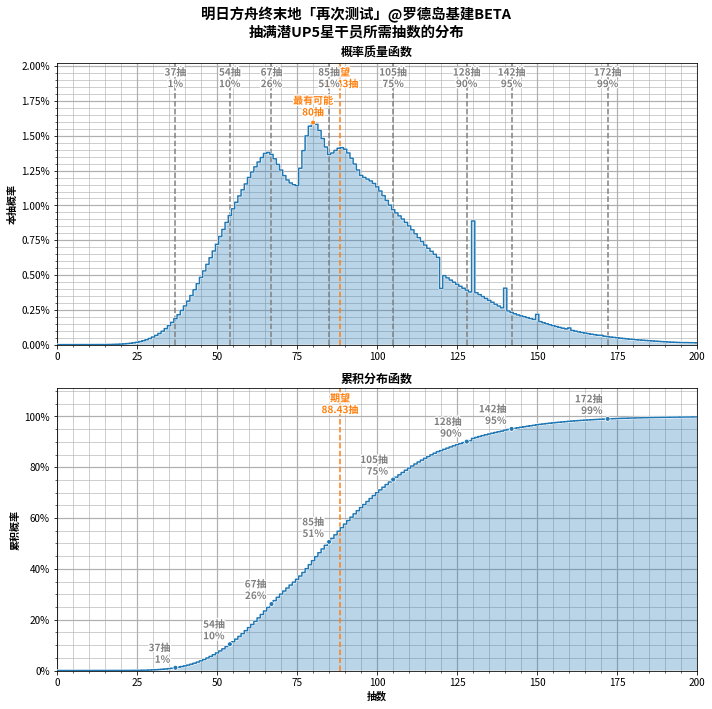

In [6]:
# 抽满潜UP5星干员

cdf = 状态分布表[:, 状态索引[最终状态]]
pmf = np.diff(cdf, prepend=0)
dist = gg.FiniteDist(pmf)
# dist.calc_dist_attribution(p_error=1)
quantile_poses = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

draw_pmf_cdf_fig(dist, "抽满潜UP5星干员所需抽数的分布", quantile_poses, drawstyle="steps-mid", x_max=200)


(<Figure size 720x432 with 1 Axes>,
 (<Axes: title={'center': '累积分布函数'}, xlabel='抽数', ylabel='累积概率'>,))

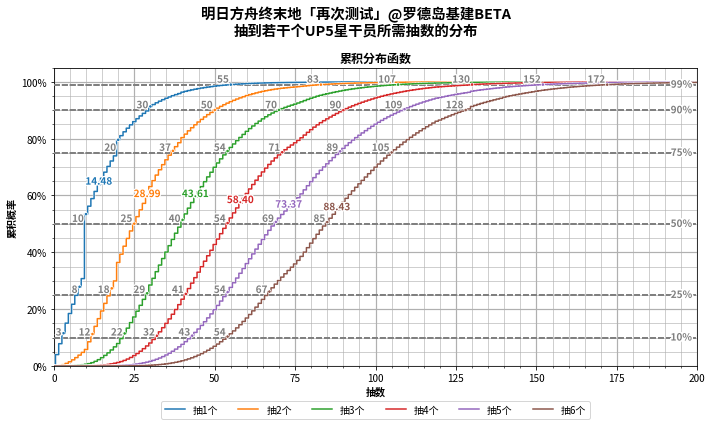

In [7]:
# 若干个UP5星干员

dists = []
for n in range(1, 7):
    符合条件的状态列表 = []
    符合条件的状态列表.extend(状态 for 状态 in 状态列表 if isinstance(状态, 过渡态类) and 状态.UP5星干员数量 >= n)
    符合条件的状态列表.append(吸收态类.已抽满潜UP5星干员)
    符合条件的状态索引列表 = np.array([状态索引[状态] for 状态 in 符合条件的状态列表])
    cdf = np.sum(状态分布表[:, 符合条件的状态索引列表], axis=1)
    pmf = np.diff(cdf, prepend=0)
    dist = gg.FiniteDist(pmf)
    dists.append(dist)

labels = [f"抽{n}个" for n in range(1, 7)]
quantile_poses = [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
draw_multi_cdf_fig(dists, labels, "抽到若干个UP5星干员所需抽数的分布", quantile_poses, drawstyle="steps-mid", x_max=200)


(<Figure size 720x720 with 2 Axes>,
 (<Axes: title={'center': '概率质量函数'}, ylabel='本抽概率'>,
  <Axes: title={'center': '累积分布函数'}, xlabel='抽数', ylabel='累积概率'>))

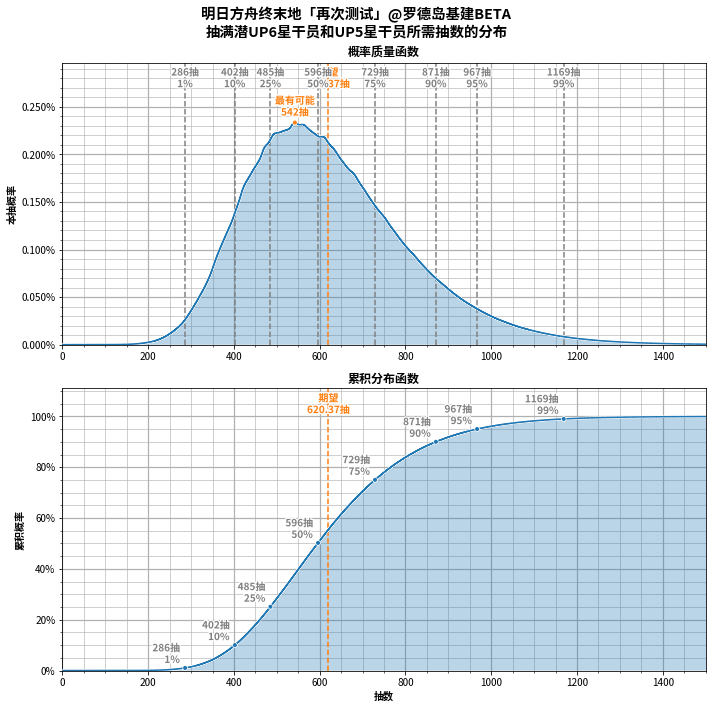

In [8]:
# 抽满潜UP6星干员和UP5星干员

type 状态 = 过渡态类 | 吸收态类


class 过渡态类(NamedTuple):
    水位_6星干员: int
    水位_5星干员: int
    UP6星干员数量: int
    UP5星干员数量: int


class 吸收态类(Enum):
    已抽满潜UP6星干员和UP5星干员 = enum.auto()


def 获取状态(水位_6星干员: int, 水位_5星干员: int, UP6星干员数量: int, UP5星干员数量: int) -> 状态:
    if UP6星干员数量 >= 6 and UP5星干员数量 >= 6:
        return 吸收态类.已抽满潜UP6星干员和UP5星干员
    else:
        UP6星干员数量 = min(UP6星干员数量, 6)
        UP5星干员数量 = min(UP5星干员数量, 6)
        return 过渡态类(水位_6星干员=水位_6星干员, 水位_5星干员=水位_5星干员, UP6星干员数量=UP6星干员数量, UP5星干员数量=UP5星干员数量)


def 状态转移_非第120抽(起始状态: 状态) -> list[tuple[状态, float]]:
    转移概率列表: list[tuple[状态, float]] = []

    if 起始状态 == 吸收态类.已抽满潜UP6星干员和UP5星干员:
        转移概率列表.append((吸收态类.已抽满潜UP6星干员和UP5星干员, 1))

    elif isinstance(起始状态, 过渡态类):
        六星概率 = operator_pity_6x[起始状态.水位_6星干员+1]
        五星概率 = operator_pity_5x[起始状态.水位_5星干员+1]
        五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
        四星概率 = 1 - 六星概率 - 五星概率

        # 抽到UP6星干员
        转移概率列表.append((获取状态(水位_6星干员=0, 水位_5星干员=0, UP6星干员数量=起始状态.UP6星干员数量+1, UP5星干员数量=起始状态.UP5星干员数量),
                       六星概率 * 抽到6星干员时是UP6星干员的概率))

        # 抽到其他6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0, UP6星干员数量=起始状态.UP6星干员数量, UP5星干员数量=起始状态.UP5星干员数量),
                       六星概率 * (1 - 抽到6星干员时是UP6星干员的概率)))

        if 起始状态.水位_6星干员 < 79:
            # 抽到UP5星干员
            转移概率列表.append((获取状态(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0, UP6星干员数量=起始状态.UP6星干员数量, UP5星干员数量=起始状态.UP5星干员数量+1),
                           五星概率 * 抽到5星干员时是UP5星干员的概率))

            # 抽到其他5星干员
            转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0, UP6星干员数量=起始状态.UP6星干员数量, UP5星干员数量=起始状态.UP5星干员数量),
                           五星概率 * (1 - 抽到5星干员时是UP5星干员的概率)))

            if 起始状态.水位_5星干员 < 9:
                # 抽到4星干员
                转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1,
                                    水位_5星干员=起始状态.水位_5星干员+1,
                                    UP6星干员数量=起始状态.UP6星干员数量,
                                    UP5星干员数量=起始状态.UP5星干员数量),
                               四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


def 状态转移_第120抽(起始状态: 状态) -> list[tuple[状态, float]]:
    if isinstance(起始状态, 过渡态类) and 起始状态.UP6星干员数量 == 0:
        return [(获取状态(水位_6星干员=0, 水位_5星干员=0, UP6星干员数量=1, UP5星干员数量=起始状态.UP5星干员数量), 1)]
    else:
        return 状态转移_非第120抽(起始状态)


状态列表 = []
k_l_range = list(itertools.product(range(7), repeat=2))
k_l_range.remove((6, 6))
状态列表.extend(过渡态类(水位_6星干员=i, 水位_5星干员=j, UP6星干员数量=k, UP5星干员数量=l)
            for i in range(80)
            for j in range(10)
            for k, l in k_l_range)
状态列表.append(吸收态类.已抽满潜UP6星干员和UP5星干员)

初始状态 = 过渡态类(水位_6星干员=0, 水位_5星干员=0, UP6星干员数量=0, UP5星干员数量=0)
最终状态 = 吸收态类.已抽满潜UP6星干员和UP5星干员

迭代次数 = 10000

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵_非第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_非第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_非第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_非第120抽 = 状态转移矩阵_非第120抽.tocsr()

状态转移矩阵_第120抽 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移_第120抽(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵_第120抽[起始状态索引, 目标状态索引] += 概率
状态转移矩阵_第120抽 = 状态转移矩阵_第120抽.tocsr()

cdf = np.zeros(迭代次数)
状态分布 = np.zeros(状态数量)
状态分布[状态索引[初始状态]] = 1
for i in range(迭代次数):
    状态转移矩阵 = 状态转移矩阵_第120抽 if i == 119 else 状态转移矩阵_非第120抽
    cdf[i] = 状态分布[状态索引[最终状态]]
    状态分布 = 状态分布 @ 状态转移矩阵

pmf = np.diff(cdf, prepend=0)
dist = gg.FiniteDist(pmf)
# dist.calc_dist_attribution(p_error=1)
quantile_poses = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

draw_pmf_cdf_fig(dist, "抽满潜UP6星干员和UP5星干员所需抽数的分布", quantile_poses, drawstyle="steps-mid", x_max=1500)


In [9]:
# 先抽到UP5星干员再抽到UP6星干员

type 状态 = 过渡态类 | 吸收态类


class 过渡态类(NamedTuple):
    水位_6星干员: int
    水位_5星干员: int


class 吸收态类(Enum):
    先抽出UP6星干员 = enum.auto()
    先抽出UP5星干员 = enum.auto()


def 状态转移(起始状态: 状态) -> list[tuple[状态, float]]:
    转移概率列表: list[tuple[状态, float]] = []

    if isinstance(起始状态, 吸收态类):
        转移概率列表.append((起始状态, 1))

    elif isinstance(起始状态, 过渡态类):
        六星概率 = operator_pity_6x[起始状态.水位_6星干员+1]
        五星概率 = operator_pity_5x[起始状态.水位_5星干员+1]
        五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
        四星概率 = 1 - 六星概率 - 五星概率

        # 抽到UP6星干员
        转移概率列表.append((吸收态类.先抽出UP6星干员, 六星概率 * 抽到6星干员时是UP6星干员的概率))

        # 抽到其他6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0),
                       六星概率 * (1 - 抽到6星干员时是UP6星干员的概率)))

        if 起始状态.水位_6星干员 < 79:
            # 抽到UP5星干员
            转移概率列表.append((吸收态类.先抽出UP5星干员,
                           五星概率 * 抽到5星干员时是UP5星干员的概率))

            # 抽到其他5星干员
            转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0),
                           五星概率 * (1 - 抽到5星干员时是UP5星干员的概率)))

            if 起始状态.水位_5星干员 < 9:
                # 抽到4星干员
                转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=起始状态.水位_5星干员+1),
                               四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


状态列表 = []
状态列表.extend(过渡态类(水位_6星干员=i, 水位_5星干员=j)
            for i in range(80)
            for j in range(10))
状态列表.append(吸收态类.先抽出UP6星干员)
状态列表.append(吸收态类.先抽出UP5星干员)

初始状态 = 过渡态类(水位_6星干员=0, 水位_5星干员=0)

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵[起始状态索引, 目标状态索引] += 概率
状态转移矩阵 = 状态转移矩阵.tocsr()

状态分布 = np.zeros(状态数量)
状态分布[状态索引[初始状态]] = 1
for i in range(119):
    状态分布 = 状态分布 @ 状态转移矩阵

print(状态分布[状态索引[吸收态类.先抽出UP5星干员]])
print(1 - 状态分布[状态索引[吸收态类.先抽出UP5星干员]])


0.9446184925834209
0.0553815074165791


In [10]:
# 干员池综合概率


type 状态类 = 过渡态类


class 过渡态类(NamedTuple):
    水位_6星干员: int
    水位_5星干员: int


def 状态转移(起始状态: 状态类) -> list[tuple[状态类, float]]:
    转移概率列表: list[tuple[状态类, float]] = []

    六星概率 = operator_pity_6x[起始状态.水位_6星干员+1]
    五星概率 = operator_pity_5x[起始状态.水位_5星干员+1]
    五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
    四星概率 = 1 - 六星概率 - 五星概率

    # 抽到6星干员
    转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0), 六星概率))

    if 起始状态.水位_6星干员 < 79:
        # 抽到5星干员
        转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0), 五星概率))

        if 起始状态.水位_5星干员 < 9:
            # 抽到4星干员
            转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=起始状态.水位_5星干员+1), 四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


状态列表 = []
状态列表.extend(过渡态类(水位_6星干员=i, 水位_5星干员=j) for i in range(80) for j in range(10))

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵[起始状态索引, 目标状态索引] += 概率
状态转移矩阵 = 状态转移矩阵.tocsr()

# 计算平稳分布
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(状态转移矩阵.T)
one_eigenvalue_index = np.argmin(np.abs(eigenvalues - 1))
stationary_distribution = np.abs(eigenvectors[:, one_eigenvalue_index])
assert np.allclose(stationary_distribution.imag, 0, atol=1e-10)
stationary_distribution = stationary_distribution.real
stationary_distribution /= stationary_distribution.sum()

综合概率_6星干员 = stationary_distribution[状态索引[过渡态类(水位_6星干员=0, 水位_5星干员=0)]]
综合概率_5星干员 = sum(stationary_distribution[状态索引[过渡态类(水位_6星干员=i, 水位_5星干员=0)]] for i in range(1, 80))

print(综合概率_6星干员, 综合概率_5星干员, 1 - 综合概率_6星干员 - 综合概率_5星干员)
# print(f"{综合概率_6星干员:.4%} {综合概率_5星干员:.4%} {1 - 综合概率_6星干员 - 综合概率_5星干员:.4%}")
# print(f"{1/综合概率_6星干员:.4f} {1/综合概率_5星干员:.4f} {1/(1 - 综合概率_6星干员 - 综合概率_5星干员):.4f}")


0.018553125748595762 0.13411295200285417 0.8473339222485501


In [11]:
# 武器池综合概率


type 状态类 = 过渡态类


class 过渡态类(NamedTuple):
    水位_6星武器: int
    水位_5星武器: int


def 状态转移(起始状态: 状态类) -> list[tuple[状态类, float]]:
    转移概率列表: list[tuple[状态类, float]] = []

    六星概率 = weapon_pity_6x[起始状态.水位_6星武器+1]
    五星概率 = weapon_pity_5x[起始状态.水位_5星武器+1]
    五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
    四星概率 = 1 - 六星概率 - 五星概率

    # 抽到6星干员
    转移概率列表.append((过渡态类(水位_6星武器=0, 水位_5星武器=0), 六星概率))

    if 起始状态.水位_6星武器 < 39:
        # 抽到5星干员
        转移概率列表.append((过渡态类(水位_6星武器=起始状态.水位_6星武器+1, 水位_5星武器=0), 五星概率))

        if 起始状态.水位_5星武器 < 9:
            # 抽到4星干员
            转移概率列表.append((过渡态类(水位_6星武器=起始状态.水位_6星武器+1, 水位_5星武器=起始状态.水位_5星武器+1), 四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


状态列表 = []
状态列表.extend(过渡态类(水位_6星武器=i, 水位_5星武器=j) for i in range(40) for j in range(10))

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵[起始状态索引, 目标状态索引] += 概率
状态转移矩阵 = 状态转移矩阵.tocsr()

# 计算平稳分布
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(状态转移矩阵.T)
one_eigenvalue_index = np.argmin(np.abs(eigenvalues - 1))
stationary_distribution = np.abs(eigenvectors[:, one_eigenvalue_index])
assert np.allclose(stationary_distribution.imag, 0, atol=1e-10)
stationary_distribution = stationary_distribution.real
stationary_distribution /= stationary_distribution.sum()

综合概率_6星干员 = stationary_distribution[状态索引[过渡态类(水位_6星武器=0, 水位_5星武器=0)]]
综合概率_5星干员 = sum(stationary_distribution[状态索引[过渡态类(水位_6星武器=i, 水位_5星武器=0)]] for i in range(1, 40))

print(综合概率_6星干员, 综合概率_5星干员, 1 - 综合概率_6星干员 - 综合概率_5星干员)
print(f"{综合概率_6星干员:.4%} {综合概率_5星干员:.4%} {1 - 综合概率_6星干员 - 综合概率_5星干员:.4%}")
print(f"{1/综合概率_6星干员:.4f} {1/综合概率_5星干员:.4f} {1/(1 - 综合概率_6星干员 - 综合概率_5星干员):.4f}")


0.04971205235439452 0.17266697878473963 0.7776209688608657
4.9712% 17.2667% 77.7621%
20.1158 5.7915 1.2860


In [2]:
# 抽到UP6星干员时，歪的6星干员数量的分布

type 状态 = 过渡态类 | 吸收态类


class 过渡态类(NamedTuple):
    水位_6星干员: int
    水位_5星干员: int
    歪的6星干员数量: int
    抽出的5星干员数量: int


class 吸收态类(NamedTuple):
    歪的6星干员数量: int
    抽出的5星干员数量: int


def 状态转移(起始状态: 状态) -> list[tuple[状态, float]]:
    转移概率列表: list[tuple[状态, float]] = []

    if isinstance(起始状态, 吸收态类):
        转移概率列表.append((起始状态, 1))

    elif isinstance(起始状态, 过渡态类):
        六星概率 = operator_pity_6x[起始状态.水位_6星干员+1]
        五星概率 = operator_pity_5x[起始状态.水位_5星干员+1]
        五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
        四星概率 = 1 - 六星概率 - 五星概率

        # 抽到UP6星干员
        转移概率列表.append((吸收态类(歪的6星干员数量=起始状态.歪的6星干员数量, 抽出的5星干员数量=起始状态.抽出的5星干员数量), 六星概率 * 抽到6星干员时是UP6星干员的概率))

        # 抽到其他6星干员
        转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0, 歪的6星干员数量=min(起始状态.歪的6星干员数量+1, M), 抽出的5星干员数量=起始状态.抽出的5星干员数量),
                       六星概率 * (1 - 抽到6星干员时是UP6星干员的概率)))

        if 起始状态.水位_6星干员 < 79:
            # 抽到5星干员
            转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0, 歪的6星干员数量=起始状态.歪的6星干员数量, 抽出的5星干员数量=min(起始状态.抽出的5星干员数量+1, N)),
                           五星概率))

            if 起始状态.水位_5星干员 < 9:
                # 抽到4星干员
                转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=起始状态.水位_5星干员+1, 歪的6星干员数量=起始状态.歪的6星干员数量, 抽出的5星干员数量=起始状态.抽出的5星干员数量),
                               四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


M = 6
N = 30

状态列表 = []
状态列表.extend(过渡态类(水位_6星干员=i, 水位_5星干员=j, 歪的6星干员数量=k, 抽出的5星干员数量=l) for i in range(80) for j in range(10) for k in range(M+1) for l in range(N+1))
状态列表.extend(吸收态类(歪的6星干员数量=i, 抽出的5星干员数量=j) for i in range(120) for j in range(120))

初始状态 = 过渡态类(水位_6星干员=0, 水位_5星干员=0, 歪的6星干员数量=0, 抽出的5星干员数量=0)

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵[起始状态索引, 目标状态索引] += 概率
状态转移矩阵 = 状态转移矩阵.tocsr()

状态分布 = np.zeros(状态数量)
状态分布[状态索引[初始状态]] = 1
for i in range(119):
    状态分布 = 状态分布 @ 状态转移矩阵

联合分布矩阵 = np.zeros((M+1, N+1))
for k in range(M+1):
    for l in range(N+1):
        联合分布矩阵[k, l] = 状态分布[状态索引[吸收态类(歪的6星干员数量=k, 抽出的5星干员数量=l)]] \
            + sum(状态分布[状态索引[过渡态类(水位_6星干员=i, 水位_5星干员=j, 歪的6星干员数量=k, 抽出的5星干员数量=l)]] for i in range(80) for j in range(10))


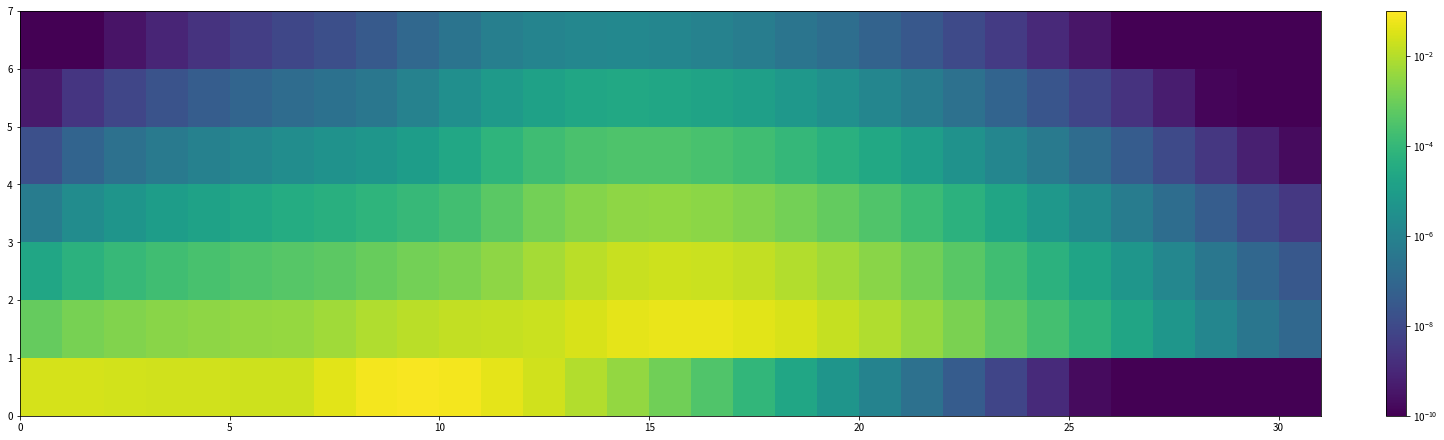

In [5]:
import pandas as pd
plt.figure(figsize=(20, 6), layout="constrained")

联合分布矩阵 = np.zeros((M+1, N+1))
for k in range(M+1):
    for l in range(N+1):
        联合分布矩阵[k, l] = 状态分布[状态索引[吸收态类(歪的6星干员数量=k, 抽出的5星干员数量=l)]] \
            + sum(状态分布[状态索引[过渡态类(水位_6星干员=i, 水位_5星干员=j, 歪的6星干员数量=k, 抽出的5星干员数量=l)]] for i in range(80) for j in range(10))

df = pd.DataFrame(联合分布矩阵)
df.to_clipboard()

plt.pcolormesh(联合分布矩阵, cmap="viridis", norm=colors.LogNorm(vmin=1e-10, vmax=1e-1))
plt.colorbar()
plt.show()


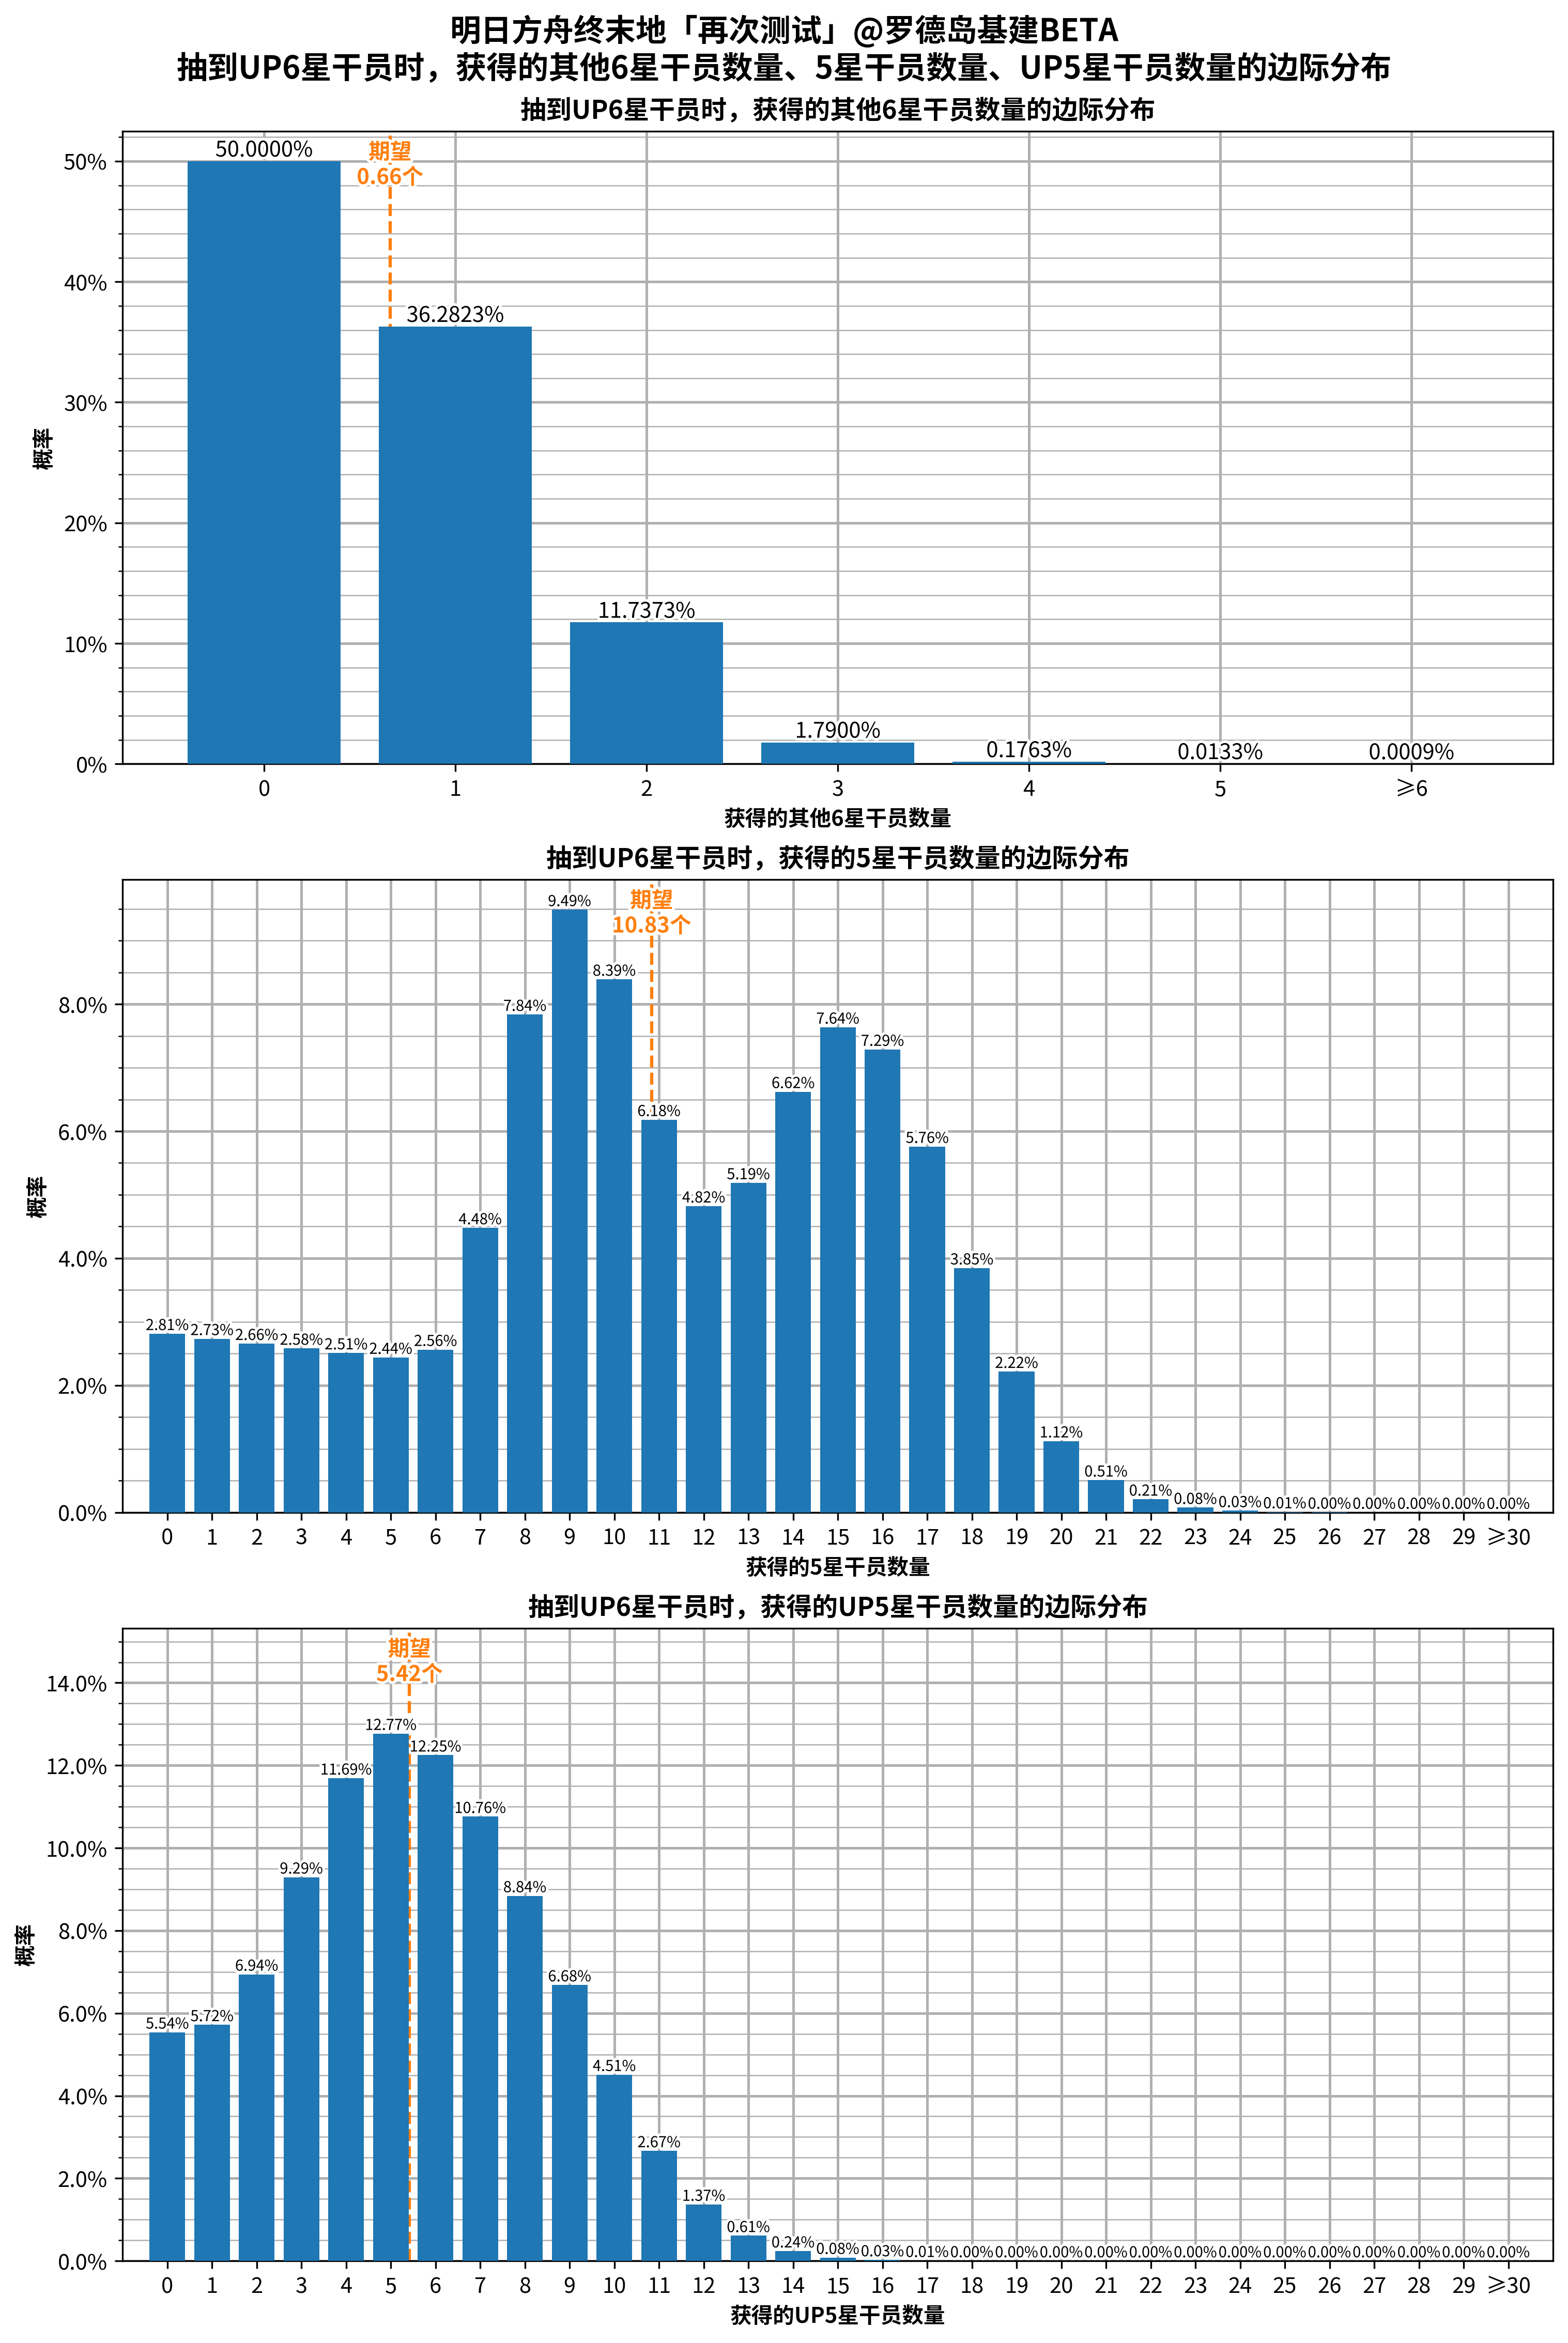

In [8]:
边际分布律_歪的6星干员 = 联合分布矩阵.sum(axis=1)
边际分布律_抽出的5星干员 = 联合分布矩阵.sum(axis=0)
边际分布律_抽出的UP5星干员 = np.zeros(N+1)
for i in range(N+1):
    边际分布律_抽出的UP5星干员[i] = sum(边际分布律_抽出的5星干员[j] * scipy.stats.binom(j, 1/2).pmf(i) for j in range(N+1))

fig = plt.figure(figsize=(10, 15), layout="constrained", dpi=300)
ax1, ax2, ax3 = fig.subplots(3, 1)
ax1: plt.Axes  # type: ignore
ax2: plt.Axes  # type: ignore
ax3: plt.Axes  # type: ignore

ax1.bar(range(M+1), 边际分布律_歪的6星干员, zorder=10)
ax2.bar(range(N+1), 边际分布律_抽出的5星干员, zorder=10)
ax3.bar(range(N+1), 边际分布律_抽出的UP5星干员, zorder=10)
ax1_y_top = np.max(边际分布律_歪的6星干员) * 1.05
ax2_y_top = np.max(边际分布律_抽出的5星干员) * 1.05
ax3_y_top = np.max(边际分布律_抽出的UP5星干员) * 1.2

# 图表标题、坐标轴标签
fig.suptitle(f"明日方舟终末地「再次测试」@罗德岛基建BETA\n抽到UP6星干员时，获得的其他6星干员数量、5星干员数量、UP5星干员数量的边际分布", fontweight="bold", fontsize="x-large")
ax1.set_title("抽到UP6星干员时，获得的其他6星干员数量的边际分布", fontweight="bold")
ax2.set_title("抽到UP6星干员时，获得的5星干员数量的边际分布", fontweight="bold")
ax3.set_title("抽到UP6星干员时，获得的UP5星干员数量的边际分布", fontweight="bold")
ax1.set_ylabel("概率", fontweight="bold")
ax2.set_ylabel("概率", fontweight="bold")
ax3.set_ylabel("概率", fontweight="bold")
ax1.set_xlabel("获得的其他6星干员数量", fontweight="bold")
ax2.set_xlabel("获得的5星干员数量", fontweight="bold")
ax3.set_xlabel("获得的UP5星干员数量", fontweight="bold")

ax1.set_xticks(range(M+1), list(range(M)) + [f"≥{M}"])
ax2.set_xticks(range(N+1), list(range(N)) + [f"≥{N}"])
ax3.set_xticks(range(N+1), list(range(N)) + [f"≥{N}"])

# 显示概率具体数值
for i, p in enumerate(边际分布律_歪的6星干员):
    ax1.annotate(f"{p:.4%}", (i, p), textcoords="offset points", xytext=(0, 0), ha="center", va="bottom", path_effects=stroke_white)

for i, p in enumerate(边际分布律_抽出的5星干员):
    ax2.annotate(f"{p:.2%}", (i, p), textcoords="offset points", xytext=(0, 0), ha="center", va="bottom", path_effects=stroke_white, fontsize=7)

for i, p in enumerate(边际分布律_抽出的UP5星干员):
    ax3.annotate(f"{p:.2%}", (i, p), textcoords="offset points", xytext=(0, 0), ha="center", va="bottom", path_effects=stroke_white, fontsize=7)

# 期望值
E_歪的6星干员 = sum(i * p for i, p in enumerate(边际分布律_歪的6星干员))
E_抽出的5星干员 = sum(i * p for i, p in enumerate(边际分布律_抽出的5星干员))
E_抽出的UP5星干员 = sum(i * p for i, p in enumerate(边际分布律_抽出的UP5星干员))
ax1.axvline(E_歪的6星干员, color="C1", linestyle="--")
ax2.axvline(E_抽出的5星干员, color="C1", linestyle="--")
ax3.axvline(E_抽出的UP5星干员, color="C1", linestyle="--")
ax1.annotate(f"期望\n{E_歪的6星干员:.2f}个", (E_歪的6星干员, ax1_y_top),
             ha="center", va="top", xytext=(0, -5), textcoords="offset points",
             color="C1", fontweight="bold", path_effects=stroke_white)
ax2.annotate(f"期望\n{E_抽出的5星干员:.2f}个", (E_抽出的5星干员, ax2_y_top),
             ha="center", va="top", xytext=(0, -5), textcoords="offset points",
             color="C1", fontweight="bold", path_effects=stroke_white)
ax3.annotate(f"期望\n{E_抽出的UP5星干员:.2f}个", (E_抽出的UP5星干员, ax3_y_top),
             ha="center", va="top", xytext=(0, -5), textcoords="offset points",
             color="C1", fontweight="bold", path_effects=stroke_white)


for ax in (ax1, ax2, ax3):
    # 显示网格
    ax.yaxis.minorticks_on()
    ax.grid(True, which="major", linewidth=1.2)
    ax.yaxis.grid(True, which="minor", linewidth=0.6)

    # y 轴标签显示为百分比
    ax.yaxis.set_major_formatter(PercentFormatter(1))

# ax1.set_xlim(-.9, M+.9)
ax2.set_xlim(-1, N+1)
ax3.set_xlim(-1, N+1)

ax1.set_ylim(0, ax1_y_top)
ax2.set_ylim(0, ax2_y_top)
ax3.set_ylim(0, ax3_y_top)

fig.savefig(f"图片/抽到UP6星干员时，获得的其他6星干员数量、5星干员数量、UP5星干员数量的边际分布.png", dpi=300)


In [157]:
print(f"{np.sum(边际分布律_抽出的UP5星干员[6:]):.4%}")
print(f"{边际分布律_抽出的UP5星干员[0]:.4%}")
歪的6星干员数量的期望 = sum(i * 边际分布律_歪的6星干员[i] for i in range(M+1))
抽出的5星干员数量的期望 = sum(i * 边际分布律_抽出的5星干员[i] for i in range(N+1))

抽到1个UP6星干员所需抽数的期望 = 81.37567691676523

综合出率_6星 = (歪的6星干员数量的期望+1) / 抽到1个UP6星干员所需抽数的期望
综合出率_5星 = 抽出的5星干员数量的期望 / 抽到1个UP6星干员所需抽数的期望
综合出率_4星 = 1 - 综合出率_6星 - 综合出率_5星

print(f"{1/抽到1个UP6星干员所需抽数的期望} {歪的6星干员数量的期望 / 抽到1个UP6星干员所需抽数的期望} {综合出率_5星} {综合出率_4星}")
print(f"{综合出率_6星:.4%} {综合出率_5星:.4%} {综合出率_4星:.4%}")
print(f"{1/综合出率_6星:.4f} {1/综合出率_5星:.4f} {1/综合出率_4星:.4f}")


48.0468%
5.5382%
0.012288684259091888 0.008098692823327688 0.1331468995428358 0.8464657233747447
2.0387% 13.3147% 84.6466%
49.0500 7.5105 1.1814
